In [1]:
# Food Ingredient Prediction with GPT-4
# Zero-shot and Few-shot Learning

import os
import json
import random
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from openai import OpenAI
from dotenv import load_dotenv
from PIL import Image
from IPython.display import display
import base64

# caching
import hashlib
import pickle
from diskcache import Cache
import contextlib

cache = Cache("./gpt4_cache")

In [2]:
# LLM Tracing

# from traceloop.sdk import Traceloop

# Traceloop.init()

In [3]:
# Load environment variables
load_dotenv()

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Set random seed for reproducibility
random.seed(42)

In [4]:
# ==== Visualization Parameters
# Define colors [zero-shot, few-shot, many-shot]
COLORS_GPT4O_MINI = ['#FFA07A', '#FA8072', '#CD5C5C']
COLORS_GPT4O = ['#87CEFA', '#1E90FF', '#4169E1']

In [5]:
# Load and prepare data
def load_data(file_path):
    with open(file_path, 'r') as f:
        return [json.loads(line) for line in f]

train_data = load_data('food-ingredients-101/train.jsonl')
test_data = load_data('food-ingredients-101/test.jsonl')

# show 4 examples from the training set
# [{'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1005649.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1014775.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1026328.jpg'}, {'prefix': '', 'suffix': 'pastry, butter, flour, granulated white sugar, brown sugar, baking apples, ground cinnamon, nutmeg', 'image': 'food-101/images/apple_pie/1028787.jpg'}]
def show_examples(data):
    from IPython.display import display, HTML
    html_content = ""
    for i in range(3):
        image = Image.open(data[i]['image'])
        image = image.resize((256, 256))
        caption = data[i]['suffix']
        wrapped_caption = '<br>'.join([caption[i:i+50] for i in range(0, len(caption), 50)])
        html_content += f"<img src='{data[i]['image']}' style='width: 256px; height: 256px; margin: 10px;'><div style='display: inline-block; vertical-align: top; margin: 10px; max-width: 256px;'><p>{wrapped_caption}</p></div>"
    display(HTML(html_content))

show_examples(train_data)

In [6]:
# Helper functions for data preprocessing

# function for checking valid img data
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            # Check file format
            if img.format.lower() not in ['png', 'jpeg', 'jpg', 'gif', 'webp']:
                return False
            # Check file size (20MB = 20 * 1024 * 1024 bytes)
            if os.path.getsize(image_path) > 20 * 1024 * 1024:
                return False
        return True
    except Exception:
        return False

def stratified_sample(data, n):
    # Group the data by class (assuming the class is the first part of the image path)
    classes = {}
    for item in data:
        class_name = item['image'].split('/')[3]  # Adjust this index if necessary
        if class_name not in classes:
            classes[class_name] = []
        classes[class_name].append(item)

    # Calculate the number of samples per class
    num_classes = len(classes)
    samples_per_class = n // num_classes

    # Perform stratified sampling with validation
    stratified_sample = []
    class_counts = {}
    for class_name, items in classes.items():
        valid_items = [item for item in items if is_valid_image(item['image'])]
        if len(valid_items) >= samples_per_class:
            selected = random.sample(valid_items, samples_per_class)
            stratified_sample.extend(selected)
            class_counts[class_name] = len(selected)
        else:
            stratified_sample.extend(valid_items)
            class_counts[class_name] = len(valid_items)
    
    # If we don't have enough samples, add more from classes with extra valid samples
    while len(stratified_sample) < n:
        for class_name, items in classes.items():
            if len(stratified_sample) >= n:
                break
            valid_items = [item for item in items if is_valid_image(item['image']) and item not in stratified_sample]
            if valid_items:
                stratified_sample.append(random.choice(valid_items))
                class_counts[class_name] += 1

    # Print the list of classes and their counts
    print("Classes and their sample counts:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

    return stratified_sample[:n]

In [7]:
# Helper functions for evaluation

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

def preprocess_ingredients(ingredient_string):
    return set(ingredient_string.lower().split(', '))

def ingredient_overlap_f1_sklearn(references, candidates, method):
    mlb = MultiLabelBinarizer()
    
    all_ingredients = set()
    for ref, cand in zip(references, candidates):
        all_ingredients.update(preprocess_ingredients(ref))
        all_ingredients.update(preprocess_ingredients(cand))
    
    mlb.fit([all_ingredients])
    
    y_true = mlb.transform([preprocess_ingredients(ref) for ref in references])
    y_pred = mlb.transform([preprocess_ingredients(cand) for cand in candidates])
    
    if method == 'sklearn':
        return np.mean([f1_score(yt, yp, average='binary', zero_division=0) for yt, yp in zip(y_true, y_pred)])
    elif method in ['weighted', 'macro', 'samples']:
        return f1_score(y_true, y_pred, average=method, zero_division=0)
    else:
        raise ValueError("Invalid method. Choose 'sklearn', 'weighted', 'macro', or 'samples'.")

def calculate_accuracy(ground_truths, predictions):
    total_correct = 0
    total_ingredients = 0
    
    for gt, pred in zip(ground_truths, predictions):
        gt_ingredients = preprocess_ingredients(gt)
        pred_ingredients = preprocess_ingredients(pred)
        
        correct = len(gt_ingredients.intersection(pred_ingredients))
        total_correct += correct
        total_ingredients += len(gt_ingredients)
    
    return total_correct / total_ingredients if total_ingredients > 0 else 0

def calculate_bleu(reference, hypothesis):
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=SmoothingFunction().method1)

rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def calculate_rouge(reference, hypothesis):
    scores = rouge_scorer_obj.score(reference, hypothesis)
    return (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3


# Main Evaluation function
def evaluate(predictions, ground_truth):
    # Prepare data for sklearn metrics
    mlb = MultiLabelBinarizer()
    all_ingredients = set()
    for ref, pred in zip(ground_truth, predictions):
        all_ingredients.update(ref.lower().split(','))
        all_ingredients.update(pred.lower().split(','))
    mlb.fit([all_ingredients])
    
    y_true = mlb.transform([set(ref.lower().split(',')) for ref in ground_truth])
    y_pred = mlb.transform([set(pred.lower().split(',')) for pred in predictions])

    # Calculate BLEU and ROUGE scores
    bleu_scores = [calculate_bleu(true, pred) for true, pred in zip(ground_truth, predictions)]
    rouge_scores = [calculate_rouge(true, pred) for true, pred in zip(ground_truth, predictions)]
    
    # Calculate sklearn-based metrics
    accuracy = calculate_accuracy(ground_truth, predictions)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Calculate various F1 scores
    f1_sklearn = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='sklearn')
    f1_sample = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='samples')
    f1_weighted = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='weighted')
    f1_macro = ingredient_overlap_f1_sklearn(ground_truth, predictions, method='macro')
    
    return {
        "bleu": np.mean(bleu_scores),
        "rouge": np.mean(rouge_scores),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_sklearn": f1_sklearn,
        "f1_sample": f1_sample,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro
    }


In [8]:
# Functions for prediction

# generate cache key
def generate_cache_key(model, messages):
    key = f"{model}_{hashlib.md5(pickle.dumps(messages)).hexdigest()}"
    return key

# Zero-shot prediction
def zero_shot_predict(image_path):
    # Encode the image
    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    prompt = f"""Given an image of a food dish, list the main ingredients used to prepare it. 
    Provide the ingredients as a comma-separated list.
    Ingredients:"""
    
    messages = [
        {"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
        ]}
    ]

    cache_key = generate_cache_key(MODEL, messages)
    
    if cache_key in cache:
        return cache[cache_key]
    
    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        max_tokens=200
    )
    result = response.choices[0].message.content.strip()
    
    cache[cache_key] = result
    return result

# Few-shot prediction
def few_shot_predict(image_path, examples):
    prompt = "Given an image of a food dish, list the main ingredients used to prepare it. Provide the ingredients as a comma-separated list.\n\n"
    
    messages = []
    for example in examples:
        with open(example['image'], "rb") as image_file:
            encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
        messages.append({"role": "user", "content": [
            {"type": "text", "text": prompt},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
        ]})
        messages.append({"role": "assistant", "content": example['suffix']})

    with open(image_path, "rb") as image_file:
        encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

    messages.append({"role": "user", "content": [
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_image}"}}
    ]})

    cache_key = generate_cache_key(MODEL, messages)
    
    if cache_key in cache:
        return cache[cache_key]
    
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=messages,
            max_tokens=200
        )
        result = response.choices[-1].message.content.strip()
        cache[cache_key] = result
        return result
    except Exception as e:
        print(f"Error in API call: {str(e)}")
        return None

In [48]:
# Visualize results
import matplotlib.pyplot as plt

def visualize_results(zero_shot_results, few_shot_results, many_shot_results, colors, comparison=False, compare_results=None):
    metrics = ['accuracy', 'precision', 'recall', 'f1_sample', 'f1_weighted', 'f1_macro']
    zero_shot_scores = [zero_shot_results[metric] for metric in metrics]
    few_shot_scores = [few_shot_results[metric] for metric in metrics]
    many_shot_scores = [many_shot_results[metric] for metric in metrics]

    x = range(len(metrics))
    
    if not comparison:
        width = 0.25  # Reduced width to accommodate three bars
        fig, ax = plt.subplots(figsize=(12, 4))
        
        # Add light grey background horizontal lines
        ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.7)
        
        ax.bar([i - width for i in x], zero_shot_scores, width, label='Zero-shot', color=colors[0])
        ax.bar([i for i in x], few_shot_scores, width, label='Few-shot', color=colors[1])
        ax.bar([i + width for i in x], many_shot_scores, width, label='Many-shot', color=colors[2])

        ax.set_ylabel('Scores')
        ax.set_title('Zero-shot vs Few-shot vs Many-shot Performance')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()

        # Set the background color to white to make the grid lines more visible
        ax.set_facecolor('white')
        
        # Ensure grid lines are behind the bars
        ax.set_axisbelow(True)
    else:
        if compare_results is None:
            raise ValueError("compare_results must be provided for comparison")
        
        zero_shot_scores_gpt4o = [compare_results['zero_shot'][metric] for metric in metrics]
        few_shot_scores_gpt4o = [compare_results['few_shot'][metric] for metric in metrics]
        many_shot_scores_gpt4o = [compare_results['many_shot'][metric] for metric in metrics]

        width = 0.12  # Adjusted width to fit all bars
        fig, ax = plt.subplots(figsize=(14, 6))

        # Add light grey background horizontal lines
        ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey', alpha=0.7)
        
        ax.bar([i - 2.5*width for i in x], zero_shot_scores, width, label='Zero-shot GPT-4o-mini', color=colors[0])
        ax.bar([i - 1.5*width for i in x], few_shot_scores, width, label='Few-shot GPT-4o-mini', color=colors[1])
        ax.bar([i - 0.5*width for i in x], many_shot_scores, width, label='Many-shot GPT-4o-mini', color=colors[2])
        ax.bar([i + 0.5*width for i in x], zero_shot_scores_gpt4o, width, label='Zero-shot GPT-4o', color=colors[3])
        ax.bar([i + 1.5*width for i in x], few_shot_scores_gpt4o, width, label='Few-shot GPT-4o', color=colors[4])
        ax.bar([i + 2.5*width for i in x], many_shot_scores_gpt4o, width, label='Many-shot GPT-4o', color=colors[5])

        ax.set_ylabel('Scores')
        ax.set_title('GPT-4o-mini vs GPT-4o (Zero-shot/Few-shot/Many-shot)')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45, ha='right')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Set the background color to white to make the grid lines more visible
        ax.set_facecolor('white')
        
        # Ensure grid lines are behind the bars
        ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()


def md_comparison_table(zero_shot, few_shot, many_shot, zero_shot_2=None, few_shot_2=None, many_shot_2=None):
    metrics = ['accuracy', 'precision', 'recall', 'f1_sample', 'f1_weighted', 'f1_macro']
    
    if zero_shot_2 is None:
        # Single model comparison
        md_table = "| Metric | Zero-shot | Few-shot | Many-shot |\n"
        md_table += "|--------|-----------|----------|------------|\n"
        
        for metric in metrics:
            md_table += f"| {metric} | {zero_shot[metric]:.4f} | {few_shot[metric]:.4f} | {many_shot[metric]:.4f} |\n"
    else:
        # Two model comparison
        md_table = "| Metric | Zero-shot Model 1 | Few-shot Model 1 | Many-shot Model 1 | Zero-shot Model 2 | Few-shot Model 2 | Many-shot Model 2 |\n"
        md_table += "|--------|-------------------|------------------|-------------------|-------------------|------------------|-------------------|\n"
        
        for metric in metrics:
            md_table += f"| {metric} | {zero_shot[metric]:.4f} | {few_shot[metric]:.4f} | {many_shot[metric]:.4f} | {zero_shot_2[metric]:.4f} | {few_shot_2[metric]:.4f} | {many_shot_2[metric]:.4f} |\n"
    
    from IPython.display import Markdown, display
    display(Markdown(md_table))

## First Look

In [10]:

VALIDATION_SIZE = 25  # Number of samples to use for validation

In [11]:
first_look_test_data = random.sample(test_data, VALIDATION_SIZE)

### GPT-4o-mini

In [12]:
# === PARAMETERS ===
MODEL = "gpt-4o-mini"

#### 1) Zero-Shot

In [13]:
# Run zero-shot prediction
print("Running zero-shot prediction...")
zero_shot_predictions_gpt4o_mini = []
for sample in tqdm(first_look_test_data):
    prediction = zero_shot_predict(sample['image'])
    zero_shot_predictions_gpt4o_mini.append(prediction)

Running zero-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 2083.69it/s]


In [14]:
# Evaluate zero-shot results
zero_shot_results_gpt4o_mini = evaluate(zero_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in first_look_test_data])
print("Zero-shot results:")
for key, value in zero_shot_results_gpt4o_mini.items():
    print(f"{key}: {value}")


Zero-shot results:
bleu: 0.02373532887252683
rouge: 0.19279729326233272
accuracy: 0.16883116883116883
precision: 0.31565656565656564
recall: 0.15584415584415584
f1_sklearn: 0.1867485586876891
f1_sample: 0.1867485586876891
f1_weighted: 0.21017976732262447
f1_macro: 0.08093493807779523


#### 2) Few-Shot

In [15]:
# temporary logging
import logging

logging.basicConfig(level=logging.DEBUG)


# Run few-shot prediction
NUM_EXAMPLES = 5
print("\nRunning few-shot prediction...")
few_shot_predictions_gpt4o_mini = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100
    while prediction is None and attempts < max_attempts:
        valid_examples = []
        while len(valid_examples) < NUM_EXAMPLES:
            candidate = random.choice(train_data)
            if is_valid_image(candidate['image']):
                valid_examples.append(candidate)
        try:
            prediction = few_shot_predict(sample['image'], valid_examples)
        except Exception as e:
            print(f"Error in few-shot prediction: {str(e)}")
        attempts += 1
    
    if prediction:
        few_shot_predictions_gpt4o_mini.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")

print(f"Number of successful predictions: {len(few_shot_predictions_gpt4o_mini)}")


Running few-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 189.34it/s]

Number of successful predictions: 25


In [16]:
# Evaluate few-shot results
if few_shot_predictions_gpt4o_mini:
    few_shot_results_gpt4o_mini = evaluate(few_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in first_look_test_data[:len(few_shot_predictions_gpt4o_mini)]])
    print("Few-shot results:")
    for key, value in few_shot_results_gpt4o_mini.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Few-shot results:
bleu: 0.029843111543786938
rouge: 0.24699057546989794
accuracy: 0.2857142857142857
precision: 0.3128186628186628
recall: 0.24242424242424243
f1_sklearn: 0.302420667778401
f1_sample: 0.302420667778401
f1_weighted: 0.3137040881196725
f1_macro: 0.1230648278924141


#### 3) Many-Shot

In [17]:
# Run many-shot prediction
NUM_EXAMPLES_MANY = 30
print("\nRunning many-shot prediction...")
many_shot_predictions_gpt4o_mini = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100  # Limit the number of attempts to prevent infinite loops
    while prediction is None and attempts < max_attempts:
        valid_examples = []
        while len(valid_examples) < NUM_EXAMPLES_MANY:
            candidate = random.choice(train_data)
            if is_valid_image(candidate['image']):
                valid_examples.append(candidate)
        prediction = few_shot_predict(sample['image'], valid_examples)
        attempts += 1
    
    if prediction:
        many_shot_predictions_gpt4o_mini.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")


Running many-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 42.71it/s]


In [18]:
# Evaluate many-shot results
if many_shot_predictions_gpt4o_mini:
    many_shot_results_gpt4o_mini = evaluate(many_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in first_look_test_data[:len(many_shot_predictions_gpt4o_mini)]])
    print("Many-shot results:")
    for key, value in many_shot_results_gpt4o_mini.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Many-shot results:
bleu: 0.028829272372881395
rouge: 0.24256921724385183
accuracy: 0.31601731601731603
precision: 0.32474747474747473
recall: 0.2857142857142857
f1_sklearn: 0.3084443544233807
f1_sample: 0.3084443544233807
f1_weighted: 0.3294913359848424
f1_macro: 0.13305041287497427


#### 4) Results

In [19]:
# Print some example predictions
print("\nExample predictions:")
for i in range(3):
    print(f"\nImage: {first_look_test_data[i]['image']}")
    print(f"Ground truth: {first_look_test_data[i]['suffix']}")
    print(f"Zero-shot prediction: {zero_shot_predictions_gpt4o_mini[i]}")
    print(f"Few-shot prediction: {few_shot_predictions_gpt4o_mini[i]}")
    print(f"Many-shot prediction: {many_shot_predictions_gpt4o_mini[i]}")


Example predictions:

Image: data/food-101/images/red_velvet_cake/3749302.jpg
Ground truth: cake, sugar, cocoa, baking powder, salt, oil, butter, egg, red food coloring, vanilla, vinegar, butter, cheese, sugar, chocolate
Zero-shot prediction: Red velvet cake, cream cheese frosting, butter, sugar, flour, cocoa powder, eggs, vanilla extract, baking powder, salt, chopped nuts.
Few-shot prediction: flour, sugar, cocoa powder, buttermilk, eggs, butter, vanilla extract, cream cheese, walnuts, red food coloring
Many-shot prediction: flour, cocoa powder, sugar, butter, egg, buttermilk, vanilla, baking powder, baking soda, cream cheese, nuts

Image: data/food-101/images/carrot_cake/3175778.jpg
Ground truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Zero-shot prediction: The main ingredients for the cake depicted are likely to include: flour, sugar, eggs, butter, baking powder, cream, and nuts (possibly walnuts or almonds).
Few-sh

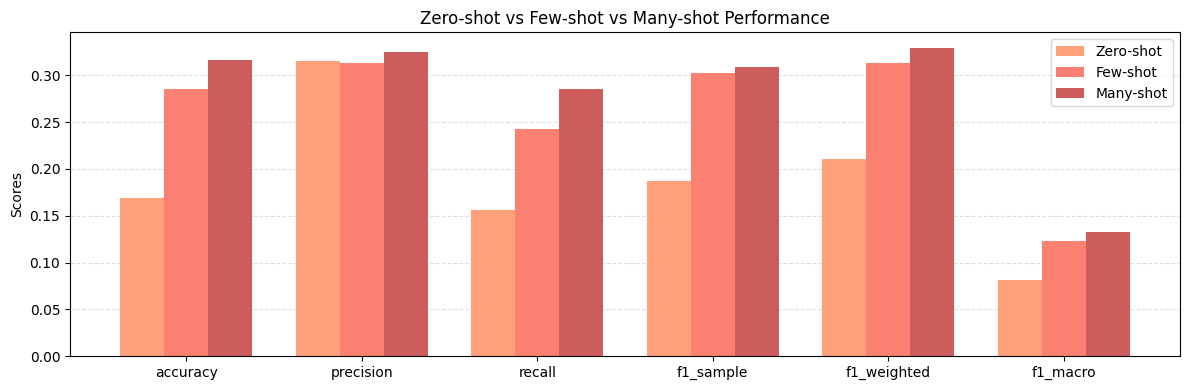

In [20]:
# visualize results
visualize_results(zero_shot_results_gpt4o_mini, few_shot_results_gpt4o_mini, many_shot_results_gpt4o_mini, COLORS_GPT4O_MINI)

### GPT-4o

In [21]:
# === PARAMETERS ===
MODEL = "gpt-4o"

#### 1) Zero-Shot

In [22]:
# Run zero-shot prediction
print("Running zero-shot prediction...")
zero_shot_predictions_gpt4o = []
for sample in tqdm(first_look_test_data):
    prediction = zero_shot_predict(sample['image'])
    zero_shot_predictions_gpt4o.append(prediction)

Running zero-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 2272.94it/s]


In [23]:
# Evaluate zero-shot results
zero_shot_results_gpt4o = evaluate(zero_shot_predictions_gpt4o, [sample['suffix'] for sample in first_look_test_data])
print("Zero-shot results:")
for key, value in zero_shot_results_gpt4o.items():
    print(f"{key}: {value}")


Zero-shot results:
bleu: 0.030494855199438196
rouge: 0.2055118992205308
accuracy: 0.1774891774891775
precision: 0.31911976911976914
recall: 0.15151515151515152
f1_sklearn: 0.18214155474155475
f1_sample: 0.18214155474155475
f1_weighted: 0.20414395609200803
f1_macro: 0.08317910879487234


#### 2) Few-Shot

In [24]:
# Run few-shot prediction
NUM_EXAMPLES = 5
print("\nRunning few-shot prediction...")
few_shot_predictions_gpt4o = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100
    while prediction is None and attempts < max_attempts:
        prediction = few_shot_predict(sample['image'], train_data[:NUM_EXAMPLES])
        attempts += 1
    if prediction:
        few_shot_predictions_gpt4o.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")


Running few-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 314.38it/s]


In [25]:
# Evaluate few-shot results
if few_shot_predictions_gpt4o:
    few_shot_results_gpt4o = evaluate(few_shot_predictions_gpt4o, [sample['suffix'] for sample in first_look_test_data[:len(few_shot_predictions_gpt4o)]])
    print("Few-shot results:")
    for key, value in few_shot_results_gpt4o.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Few-shot results:
bleu: 0.032270539270586054
rouge: 0.279888326759432
accuracy: 0.2943722943722944
precision: 0.3458707958707959
recall: 0.2554112554112554
f1_sklearn: 0.2849463056461557
f1_sample: 0.2849463056461557
f1_weighted: 0.3175836304810779
f1_macro: 0.13452340257948445


#### 3) Many-Shot

In [26]:
# Run many-shot prediction
NUM_EXAMPLES_MANY = 30
print("\nRunning many-shot prediction...")
many_shot_predictions_gpt4o = []
for sample in tqdm(first_look_test_data[:VALIDATION_SIZE]):
    prediction = None
    attempts = 0
    max_attempts = 100
    while prediction is None and attempts < max_attempts:
        prediction = few_shot_predict(sample['image'], train_data[:NUM_EXAMPLES_MANY])
        attempts += 1
    if prediction:
        many_shot_predictions_gpt4o.append(prediction)
    else:
        print(f"Skipping sample after {max_attempts} failed attempts")


Running many-shot prediction...


100%|██████████| 25/25 [00:00<00:00, 83.68it/s]


In [27]:
# Evaluate many-shot results
if many_shot_predictions_gpt4o:
    many_shot_results_gpt4o = evaluate(many_shot_predictions_gpt4o, [sample['suffix'] for sample in first_look_test_data[:len(many_shot_predictions_gpt4o)]])
    print("Many-shot results:")
    for key, value in many_shot_results_gpt4o.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Many-shot results:
bleu: 0.030825224043968147
rouge: 0.2770804784121273
accuracy: 0.2857142857142857
precision: 0.33909690598002284
recall: 0.23809523809523808
f1_sklearn: 0.28134986620120367
f1_sample: 0.28134986620120367
f1_weighted: 0.3090929272747454
f1_macro: 0.12478034785727093


#### 4) Results

In [28]:
# Print some example predictions
print("\nExample predictions:")
for i in range(3):
    print(f"\nImage: {first_look_test_data[i]['image']}")
    print(f"Ground truth: {first_look_test_data[i]['suffix']}")
    print(f"Zero-shot prediction: {zero_shot_predictions_gpt4o[i]}")
    print(f"Few-shot prediction: {few_shot_predictions_gpt4o[i]}")
    print(f"Many-shot prediction: {many_shot_predictions_gpt4o[i]}")


Example predictions:

Image: data/food-101/images/red_velvet_cake/3749302.jpg
Ground truth: cake, sugar, cocoa, baking powder, salt, oil, butter, egg, red food coloring, vanilla, vinegar, butter, cheese, sugar, chocolate
Zero-shot prediction: Flour, sugar, eggs, butter, buttermilk, cocoa powder, red food coloring, vinegar, baking soda, cream cheese, powdered sugar, vanilla extract, crushed nuts.
Few-shot prediction: flour, sugar, cocoa powder, baking soda, salt, buttermilk, vegetable oil, eggs, red food coloring, vanilla extract, white vinegar, cream cheese, butter, powdered sugar, vanilla extract, chopped nuts
Many-shot prediction: flour, sugar, cocoa powder, baking soda, salt, buttermilk, vinegar, vanilla extract, red food coloring, vegetable oil, eggs, cream cheese, butter, powdered sugar, pecans

Image: data/food-101/images/carrot_cake/3175778.jpg
Ground truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Zero-shot pred

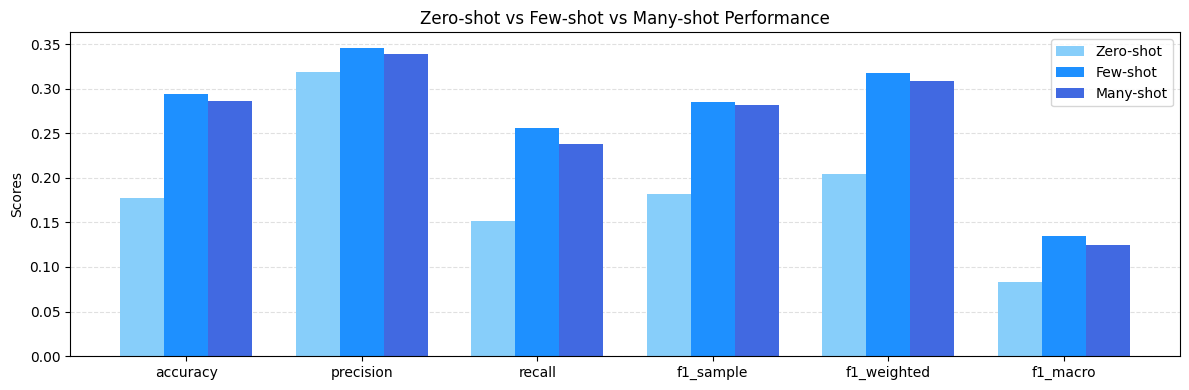

In [29]:
visualize_results(zero_shot_results_gpt4o, few_shot_results_gpt4o, many_shot_results_gpt4o, COLORS_GPT4O)


### GPT-4o vs. GPT-4o-mini (Early Trends)

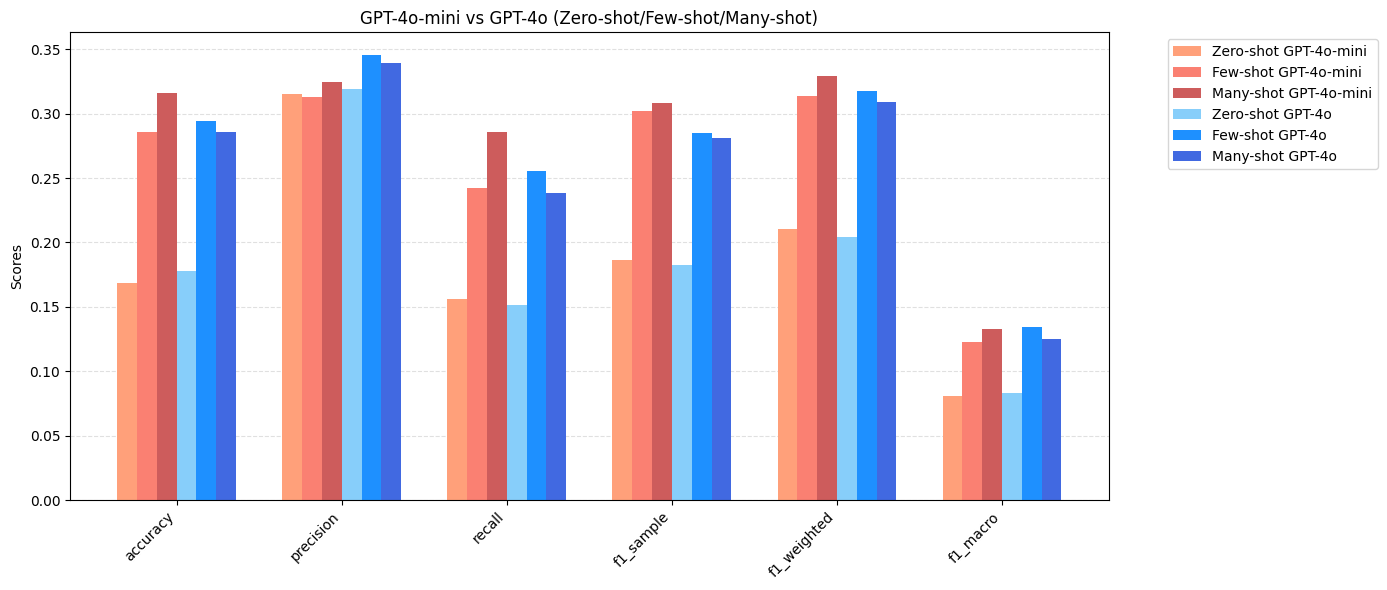

In [30]:
visualize_results(
    zero_shot_results_gpt4o_mini,
    few_shot_results_gpt4o_mini,
    many_shot_results_gpt4o_mini,
    COLORS_GPT4O_MINI + COLORS_GPT4O,
    comparison=True,
    compare_results={
        "zero_shot": zero_shot_results_gpt4o,
        "few_shot": few_shot_results_gpt4o,
        "many_shot": many_shot_results_gpt4o
    }
)

In [31]:
# Usage example:
md_comparison_table(
    zero_shot_results_gpt4o_mini,
    few_shot_results_gpt4o_mini,
    many_shot_results_gpt4o_mini,
    zero_shot_results_gpt4o,
    few_shot_results_gpt4o,
    many_shot_results_gpt4o
)

| Metric | Zero-shot GPT-4o-mini | Few-shot GPT-4o-mini | Many-shot GPT-4o-mini | Zero-shot GPT-4o | Few-shot GPT-4o | Many-shot GPT-4o |
|--------|------------------------|------------------------|-------------------------|-------------------|------------------|-------------------|
| accuracy | 0.1688 | 0.2857 | 0.3160 | 0.1775 | 0.2944 | 0.2857 |
| precision | 0.3157 | 0.3128 | 0.3247 | 0.3191 | 0.3459 | 0.3391 |
| recall | 0.1558 | 0.2424 | 0.2857 | 0.1515 | 0.2554 | 0.2381 |
| f1_sample | 0.1867 | 0.3024 | 0.3084 | 0.1821 | 0.2849 | 0.2813 |
| f1_weighted | 0.2102 | 0.3137 | 0.3295 | 0.2041 | 0.3176 | 0.3091 |
| f1_macro | 0.0809 | 0.1231 | 0.1331 | 0.0832 | 0.1345 | 0.1248 |


> ## Erste Vergleichende Analyse GPT-4o-mini und GPT-4o
>
> Unsere Ergebnisse zeigen interessante Muster beim Vergleich von GPT-4o-mini und GPT-4o:
>
> 1. GPT-4o-mini übertrifft GPT-4o in Many-Shot-Szenarien bei Genauigkeit und Recall.
> 2. GPT-4o-mini zeigt konsistente Verbesserungen von Zero-Shot zu Many-Shot.
> 3. GPT-4o erreicht seine Höchstleistung in Few-Shot-Szenarien und zeigt einen leichten Rückgang bei Many-Shot.
> 4. Die Präzision bleibt bei beiden Modellen relativ stabil, während der Recall sich verbessert.
>
> Diese Muster deuten darauf hin, dass beide Modelle mit mehr Beispielen liberaler in der Vorhersage von Zutaten werden. Wichtige Überlegungen:
>
> 1. Unser vereinfachter Datensatz enthält nur Hauptzutaten.
> 2. Die Tendenz zur Vorhersage zusätzlicher Zutaten könnte in realen Anwendungen nützlich sein.
> 3. Zusätzlich vorhergesagte Zutaten könnten in den Gerichten vorhanden sein, wurden aber aus unseren Grundwahrheitsdaten herausgefiltert.
>
> ### Implikationen
>
> 1. Die Verbesserung des Recalls ist vorteilhaft und deutet auf eine bessere Identifizierung der Kernzutaten (ingredients_simplified) hin.
> 2. Die "Übervorhersage" von Zutaten könnte wertvolle zusätzliche Informationen liefern, wird aber in unseren aktuellen Metriken bestraft.
> 3. GPT-4o-mini zeigt bemerkenswerte Anpassungsfähigkeit, besonders in Many-Shot-Szenarien.
> 4. GPT-4o zeigt Anzeichen möglicher Überanpassung in Many-Shot-Szenarien.
>
> ### Zukünftige Arbeit
>
> 1. Qualitative Bewertung zusätzlich vorhergesagter Zutaten.
> 2. Verwendung eines umfassenderen Datensatzes für die abschließende Modellbewertung.
> 3. Untersuchung der Faktoren, die zu GPT-4o-minis überlegener Leistung in Many-Shot-Szenarien beitragen.
> 4. Analyse der Gründe für GPT-4o's Leistungsrückgang in Many-Shot-Szenarien.

## GPT-4o-mini Comprehensive Evaluation


In [32]:
# === PARAMETERS ===
MODEL = "gpt-4o-mini"
FULL_VALIDATION_SIZE = 500
NUM_EXAMPLES_FEW = 5
NUM_EXAMPLES_MANY = 30
NUM_EXAMPLES_VERY_MANY = 100

cache_refresh_interval = 10  # Refresh cache every 10 successful predictions to prevent data leakage

In [33]:
comprehensive_test_data = stratified_sample(test_data, FULL_VALIDATION_SIZE)

Classes and their sample counts:
apple_pie: 5
baby_back_ribs: 5
baklava: 5
beef_carpaccio: 5
beef_tartare: 5
beet_salad: 5
beignets: 5
bibimbap: 5
bread_pudding: 5
breakfast_burrito: 5
bruschetta: 5
caesar_salad: 5
cannoli: 5
caprese_salad: 5
carrot_cake: 5
ceviche: 5
cheesecake: 5
cheese_plate: 5
chicken_curry: 5
chicken_quesadilla: 5
chicken_wings: 5
chocolate_cake: 5
chocolate_mousse: 5
churros: 5
clam_chowder: 5
club_sandwich: 5
crab_cakes: 5
creme_brulee: 5
croque_madame: 5
cup_cakes: 5
deviled_eggs: 5
donuts: 5
dumplings: 5
edamame: 5
eggs_benedict: 5
escargots: 5
falafel: 5
filet_mignon: 5
fish_and_chips: 5
foie_gras: 5
french_fries: 5
french_onion_soup: 5
french_toast: 5
fried_calamari: 5
fried_rice: 5
frozen_yogurt: 5
garlic_bread: 5
gnocchi: 5
greek_salad: 5
grilled_cheese_sandwich: 5
grilled_salmon: 5
guacamole: 5
gyoza: 5
hamburger: 5
hot_and_sour_soup: 5
hot_dog: 5
huevos_rancheros: 5
hummus: 5
ice_cream: 5
lasagna: 5
lobster_bisque: 5
lobster_roll_sandwich: 5
macaroni_and

### 1) Zero-Shot

In [34]:
# Run zero-shot prediction
print("Running zero-shot prediction...")
zero_shot_predictions_gpt4o_mini = []
processed_samples_zero_mini = set()
retry_count = 0

for sample in tqdm(comprehensive_test_data[:FULL_VALIDATION_SIZE]):
    prediction = None
    while prediction is None:
        try:
            if sample['image'] not in processed_samples_zero_mini:
                prediction = zero_shot_predict(sample['image'])
                processed_samples_zero_mini.add(sample['image'])
            else:
                # Find a new sample that hasn't been processed
                new_sample = next(s for s in test_data if s['image'] not in processed_samples_zero_mini)
                prediction = zero_shot_predict(new_sample['image'])
                processed_samples_zero_mini.add(new_sample['image'])
        except Exception as e:
            print(f"Error occurred: {e}. Retrying with a new sample.")
            retry_count += 1
    
    zero_shot_predictions_gpt4o_mini.append(prediction)

print(f"Total number of retries: {retry_count}")

Running zero-shot prediction...


100%|██████████| 500/500 [22:27<00:00,  2.69s/it]

Total number of retries: 0


In [35]:
# In-between cache closing to prevent data leakage
cache.close()
cache = Cache("./gpt4_cache")

In [36]:
# Evaluate zero-shot results
zero_shot_results_gpt4o_mini = evaluate(zero_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in comprehensive_test_data[:FULL_VALIDATION_SIZE]])
print("Zero-shot results:")
for key, value in zero_shot_results_gpt4o_mini.items():
    print(f"{key}: {value}")

Zero-shot results:
bleu: 0.0167211032643542
rouge: 0.17616019590537005
accuracy: 0.1729479768786127
precision: 0.36830282529896935
recall: 0.14678899082568808
f1_sklearn: 0.18239801583412857
f1_sample: 0.18239801583412857
f1_weighted: 0.225458799547204
f1_macro: 0.02523768063450374


### 2) Few-Shot

In [37]:
# Run few-shot prediction
print("\nRunning few-shot prediction...")
few_shot_predictions_gpt4o_mini = []
processed_samples_few_mini = set()
retry_count = 0
sample_count = 0

valid_examples = stratified_sample(train_data, NUM_EXAMPLES_FEW)
for sample in tqdm(comprehensive_test_data[:FULL_VALIDATION_SIZE]):
    prediction = None
    while prediction is None:
        try:
            if sample['image'] not in processed_samples_few_mini:
                prediction = few_shot_predict(sample['image'], valid_examples)
                processed_samples_few_mini.add(sample['image'])
            else:
                # Find a new sample that hasn't been processed
                new_sample = next(s for s in test_data if s['image'] not in processed_samples_few_mini)
                prediction = few_shot_predict(new_sample['image'], valid_examples)
                processed_samples_few_mini.add(new_sample['image'])
        except Exception as e:
            print(f"Error occurred: {e}. Retrying with a new sample.")
            retry_count += 1
    
    few_shot_predictions_gpt4o_mini.append(prediction)
    sample_count += 1

    # Refresh cache every cache_refresh_interval steps
    if sample_count % cache_refresh_interval == 0:
        cache.close()
        cache = Cache("./gpt4_cache")

print(f"Total number of retries: {retry_count}")



Running few-shot prediction...
Classes and their sample counts:
apple_pie: 1
baby_back_ribs: 1
baklava: 1
beef_carpaccio: 1
beef_tartare: 1
beet_salad: 0
beignets: 0
bibimbap: 0
bread_pudding: 0
breakfast_burrito: 0
bruschetta: 0
caesar_salad: 0
cannoli: 0
caprese_salad: 0
carrot_cake: 0
ceviche: 0
cheesecake: 0
cheese_plate: 0
chicken_curry: 0
chicken_quesadilla: 0
chicken_wings: 0
chocolate_cake: 0
chocolate_mousse: 0
churros: 0
clam_chowder: 0
club_sandwich: 0
crab_cakes: 0
creme_brulee: 0
croque_madame: 0
cup_cakes: 0
deviled_eggs: 0
donuts: 0
dumplings: 0
edamame: 0
eggs_benedict: 0
escargots: 0
falafel: 0
filet_mignon: 0
fish_and_chips: 0
foie_gras: 0
french_fries: 0
french_onion_soup: 0
french_toast: 0
fried_calamari: 0
fried_rice: 0
frozen_yogurt: 0
garlic_bread: 0
gnocchi: 0
greek_salad: 0
grilled_cheese_sandwich: 0
grilled_salmon: 0
guacamole: 0
gyoza: 0
hamburger: 0
hot_and_sour_soup: 0
hot_dog: 0
huevos_rancheros: 0
hummus: 0
ice_cream: 0
lasagna: 0
lobster_bisque: 0
lobst

100%|██████████| 500/500 [38:57<00:00,  4.67s/it]

Total number of retries: 0


In [38]:
# In-between cache closing to prevent data leakage
cache.close()
cache = Cache("./gpt4_cache")

In [39]:
# Evaluate few-shot results
if few_shot_predictions_gpt4o_mini:
    few_shot_results_gpt4o_mini = evaluate(few_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in comprehensive_test_data[:len(few_shot_predictions_gpt4o_mini)]])
    print("Few-shot results:")
    for key, value in few_shot_results_gpt4o_mini.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Few-shot results:
bleu: 0.027194462108289685
rouge: 0.23752390089989023
accuracy: 0.2776878612716763
precision: 0.37389049840563443
recall: 0.23302752293577983
f1_sklearn: 0.2811752834793975
f1_sample: 0.2811752834793975
f1_weighted: 0.3172425090772339
f1_macro: 0.07174537571412415


### 3) Many-Shot

In [40]:
# Run many-shot prediction
print("\nRunning many-shot prediction...")
many_shot_predictions_gpt4o_mini = []
processed_samples_many_mini = set()
retry_count = 0
sample_count = 0

valid_examples = stratified_sample(train_data, NUM_EXAMPLES_MANY)
for sample in tqdm(comprehensive_test_data[:FULL_VALIDATION_SIZE]):
    prediction = None
    while prediction is None:
        try:
            if sample['image'] not in processed_samples_many_mini:
                prediction = few_shot_predict(sample['image'], valid_examples)
                processed_samples_many_mini.add(sample['image'])
            else:
                # Find a new sample that hasn't been processed
                new_sample = next(s for s in test_data if s['image'] not in processed_samples_many_mini)
                prediction = few_shot_predict(new_sample['image'], valid_examples)
                processed_samples_many_mini.add(new_sample['image'])
        except Exception as e:
            print(f"Error occurred: {e}. Retrying with a new sample.")
            retry_count += 1
    
    many_shot_predictions_gpt4o_mini.append(prediction)
    sample_count += 1

    # Refresh cache every cache_refresh_interval steps
    if sample_count % cache_refresh_interval == 0:
        cache.close()
        cache = Cache("./gpt4_cache")

print(f"Total number of retries: {retry_count}")



Running many-shot prediction...
Classes and their sample counts:
apple_pie: 1
baby_back_ribs: 1
baklava: 1
beef_carpaccio: 1
beef_tartare: 1
beet_salad: 1
beignets: 1
bibimbap: 1
bread_pudding: 1
breakfast_burrito: 1
bruschetta: 1
caesar_salad: 1
cannoli: 1
caprese_salad: 1
carrot_cake: 1
ceviche: 1
cheesecake: 1
cheese_plate: 1
chicken_curry: 1
chicken_quesadilla: 1
chicken_wings: 1
chocolate_cake: 1
chocolate_mousse: 1
churros: 1
clam_chowder: 1
club_sandwich: 1
crab_cakes: 1
creme_brulee: 1
croque_madame: 1
cup_cakes: 1
deviled_eggs: 0
donuts: 0
dumplings: 0
edamame: 0
eggs_benedict: 0
escargots: 0
falafel: 0
filet_mignon: 0
fish_and_chips: 0
foie_gras: 0
french_fries: 0
french_onion_soup: 0
french_toast: 0
fried_calamari: 0
fried_rice: 0
frozen_yogurt: 0
garlic_bread: 0
gnocchi: 0
greek_salad: 0
grilled_cheese_sandwich: 0
grilled_salmon: 0
guacamole: 0
gyoza: 0
hamburger: 0
hot_and_sour_soup: 0
hot_dog: 0
huevos_rancheros: 0
hummus: 0
ice_cream: 0
lasagna: 0
lobster_bisque: 0
lobs

 14%|█▍        | 70/500 [12:11<1:16:24, 10.66s/it]

Error in API call: Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'sanitizer_server_error'}}


 15%|█▌        | 77/500 [13:23<1:14:55, 10.63s/it]

Error in API call: Error code: 500 - {'error': {'message': 'The server had an error processing your request. Sorry about that! You can retry your request, or contact us through our help center at help.openai.com if you keep seeing this error. (Please include the request ID req_bc98fe45ed3aafba781944d82c9d33ab in your email.)', 'type': 'server_error', 'param': None, 'code': None}}


 42%|████▏     | 209/500 [36:28<50:51, 10.49s/it]  

Error in API call: Error code: 400 - {'error': {'message': "You uploaded an unsupported image. Please make sure your image is below 20 MB in size and is of one the following formats: ['png', 'jpeg', 'gif', 'webp'].", 'type': 'invalid_request_error', 'param': None, 'code': 'sanitizer_server_error'}}


100%|██████████| 500/500 [1:26:36<00:00, 10.39s/it]

Total number of retries: 0


In [41]:
# In-between cache closing to prevent data leakage
cache.close()
cache = Cache("./gpt4_cache")

In [43]:
# Evaluate very-many-shot results
if many_shot_predictions_gpt4o_mini:
    many_shot_results_gpt4o_mini = evaluate(many_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in comprehensive_test_data[:len(many_shot_predictions_gpt4o_mini)]])
    print("Many-shot results:")
    for key, value in many_shot_results_gpt4o_mini.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

Many-shot results:
bleu: 0.033418394557622876
rouge: 0.2528183373694991
accuracy: 0.3447398843930636
precision: 0.3652008784396262
recall: 0.29495412844036695
f1_sklearn: 0.3391163227901229
f1_sample: 0.3391163227901229
f1_weighted: 0.35607922263506253
f1_macro: 0.0824187062832313


### 4) Very-Many-Shot

In [ ]:
# Run very-many-shot prediction
print("\nRunning very-many-shot prediction...")
very_many_shot_predictions_gpt4o_mini = []
processed_samples_very_many_mini = set()
retry_count = 0
sample_count = 0

for sample in tqdm(comprehensive_test_data[:FULL_VALIDATION_SIZE]):
    prediction = None
    while prediction is None:
        try:
            if sample['image'] not in processed_samples_very_many_mini:
                prediction = few_shot_predict(sample['image'], train_data[:NUM_EXAMPLES_VERY_MANY])
                processed_samples_very_many_mini.add(sample['image'])
            else:
                # Find a new sample that hasn't been processed
                new_sample = next(s for s in test_data if s['image'] not in processed_samples_very_many_mini)
                prediction = few_shot_predict(new_sample['image'], train_data[:NUM_EXAMPLES_VERY_MANY])
                processed_samples_very_many_mini.add(new_sample['image'])
        except Exception as e:
            print(f"Error occurred: {e}. Retrying with a new sample.")
            retry_count += 1
    
    very_many_shot_predictions_gpt4o_mini.append(prediction)
    sample_count += 1

    # Refresh cache every cache_refresh_interval steps
    if sample_count % cache_refresh_interval == 0:
        cache.close()
        cache = Cache("./gpt4_cache")

print(f"Total number of retries: {retry_count}")


In [ ]:
# Evaluate very-many-shot results
if very_many_shot_predictions_gpt4o_mini:
    very_many_shot_results_gpt4o_mini = evaluate(very_many_shot_predictions_gpt4o_mini, [sample['suffix'] for sample in first_look_test_data[:len(very_many_shot_predictions_gpt4o_mini)]])
    print("Very-many-shot results:")
    for key, value in very_many_shot_results_gpt4o_mini.items():
        print(f"{key}: {value}")
else:
    print("No valid predictions to evaluate.")

### 5) Results

In [44]:
# Print some example predictions
print("\nExample predictions:")
for i in range(3):
    print(f"\nImage: {first_look_test_data[i]['image']}")
    print(f"Ground truth: {first_look_test_data[i]['suffix']}")
    print(f"Zero-shot prediction: {zero_shot_predictions_gpt4o_mini[i]}")
    print(f"Few-shot prediction: {few_shot_predictions_gpt4o_mini[i]}")
    print(f"Many-shot prediction: {many_shot_predictions_gpt4o_mini[i]}")
    # print(f"Very-many-shot prediction: {very_many_shot_predictions_gpt4o_mini[i]}")


Example predictions:

Image: data/food-101/images/red_velvet_cake/3749302.jpg
Ground truth: cake, sugar, cocoa, baking powder, salt, oil, butter, egg, red food coloring, vanilla, vinegar, butter, cheese, sugar, chocolate
Zero-shot prediction: Based on the appearance of the dish, the main ingredients might include: almond flour, sugar, eggs, butter, powdered sugar, cream, and mint.
Few-shot prediction: almond, sugar, egg, butter, flour, lemon zest, powdered sugar, cream, mint
Many-shot prediction: flour, sugar, butter, egg, almond, vanilla, lemon, cream, mint, icing sugar

Image: data/food-101/images/carrot_cake/3175778.jpg
Ground truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Zero-shot prediction: Puff pastry, butter, sugar, eggs, filling (such as fruit, custard, or cheese).
Few-shot prediction: flour, butter, sugar, yeast, milk, salt, egg, cream cheese
Many-shot prediction: flour, butter, salt, sugar, yeast, milk, egg

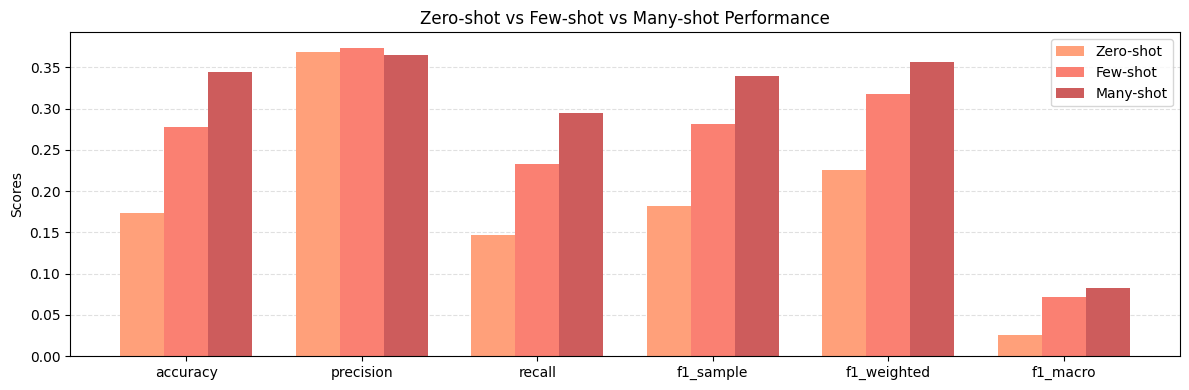

In [45]:
# Visualize results
visualize_results(
    zero_shot_results_gpt4o_mini,
    few_shot_results_gpt4o_mini,
    many_shot_results_gpt4o_mini,
    COLORS_GPT4O_MINI,
    # very_many_shot_results=very_many_shot_results_gpt4o_mini
)

In [49]:
# Generate comparison table
md_comparison_table(
    zero_shot_results_gpt4o_mini,
    few_shot_results_gpt4o_mini,
    many_shot_results_gpt4o_mini
)

| Metric | Zero-shot | Few-shot | Many-shot |
|--------|-----------|----------|------------|
| accuracy | 0.1729 | 0.2777 | 0.3447 |
| precision | 0.3683 | 0.3739 | 0.3652 |
| recall | 0.1468 | 0.2330 | 0.2950 |
| f1_sample | 0.1824 | 0.2812 | 0.3391 |
| f1_weighted | 0.2255 | 0.3172 | 0.3561 |
| f1_macro | 0.0252 | 0.0717 | 0.0824 |


# Closing Cache at the end of the script

Needed for data integrity and to free up resources

In [50]:
# close cache
cache.close()